In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to extract and save reference features (ROI and edges) of the kicker
def extract_reference_features(image_path, save_dir):
    # Load the reference image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Reference image not found.")
        return

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, 50, 150)

    # Define ROI (upper half of the image)
    height, width = edges.shape
    roi = edges[0:int(height/2), 0:width]  # Upper half of the edges image

    # Save only the ROI (upper half) and its edges
    os.makedirs(save_dir, exist_ok=True)
    cv2.imwrite(os.path.join(save_dir, 'reference_roi.jpg'), roi)          # Save ROI of edges
    cv2.imwrite(os.path.join(save_dir, 'reference_edges.jpg'), roi)        # Save the same ROI as reference edges

    print(f"Reference features saved successfully in '{save_dir}'.")

# Test the function
extract_reference_features(
    'image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at front position/Trial 1.jpg', 
    'Reference_Imgs'
)

Reference features saved successfully in 'Reference_Imgs'.


## Kicker Detection 

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect kicker based on edge similarity using feature matching
def detect_kicker_with_feature_matching(image_path, reference_roi, reference_edges, threshold=0.3):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return None  # Return None if the image is not found

    # Step 1: Image Preprocessing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Step 2: Edge Detection
    edges = cv2.Canny(blurred_image, 50, 150)

    # Step 3: Define ROI (upper half of the image)
    height, width = edges.shape
    roi = edges[0:int(height/2), 0:width]

    # Step 4: Feature Matching with ORB
    orb = cv2.ORB_create()

    # Detect keypoints and descriptors in reference and current ROI
    keypoints_ref, descriptors_ref = orb.detectAndCompute(reference_edges, None)
    keypoints_roi, descriptors_roi = orb.detectAndCompute(roi, None)

    # Check if keypoints are found
    if descriptors_ref is None or descriptors_roi is None:
        print("No keypoints detected in one of the images.")
        return None

    # Create BFMatcher object based on Hamming distance (suitable for ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(descriptors_ref, descriptors_roi)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance

    # Visualization of matches
    match_image = cv2.drawMatches(reference_edges, keypoints_ref, roi, keypoints_roi, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Calculate similarity based on good matches
    good_matches = [m for m in matches if m.distance < 50]  # Threshold for good matches
    similarity_score = len(good_matches) / len(matches) if matches else 0  # Similarity score

    kicker_detected = similarity_score >= threshold

    # Visualization
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Detected Edges")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(reference_edges, cmap='gray')
    plt.title("Reference Edges")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(match_image)
    plt.title(f"Feature Matching\n(Similarity Score: {similarity_score:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    if kicker_detected:
        print(f"Kicker detected with similarity score: {similarity_score:.2f}")
    else:
        print("No kicker detected.")

    return kicker_detected

# Test the function
reference_roi = cv2.imread('Reference_Imgs/reference_roi.jpg', cv2.IMREAD_GRAYSCALE)
reference_edges = cv2.imread('Reference_Imgs/reference_edges.jpg', cv2.IMREAD_GRAYSCALE)

## Testing for True Cases

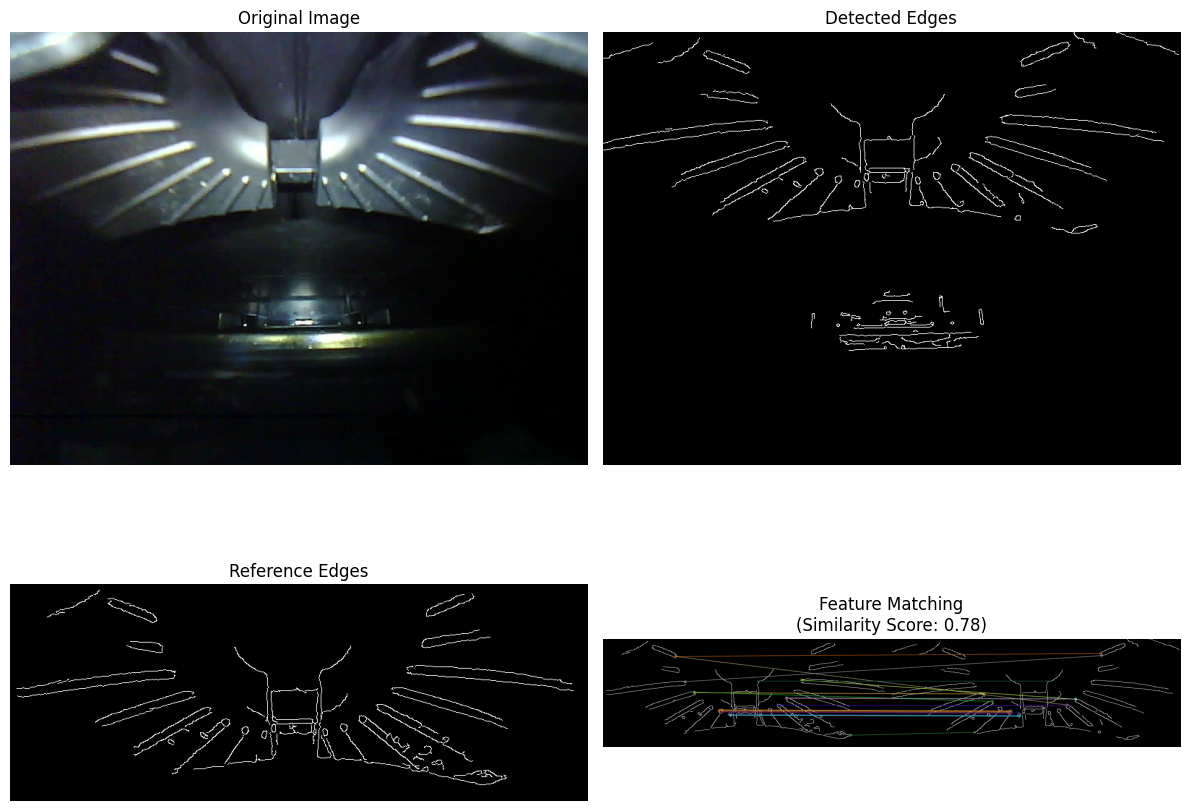

Kicker detected with similarity score: 0.78


True

In [34]:
detect_kicker_with_feature_matching('image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at front position/Trial 3.jpg', reference_roi, reference_edges, threshold=0.7)

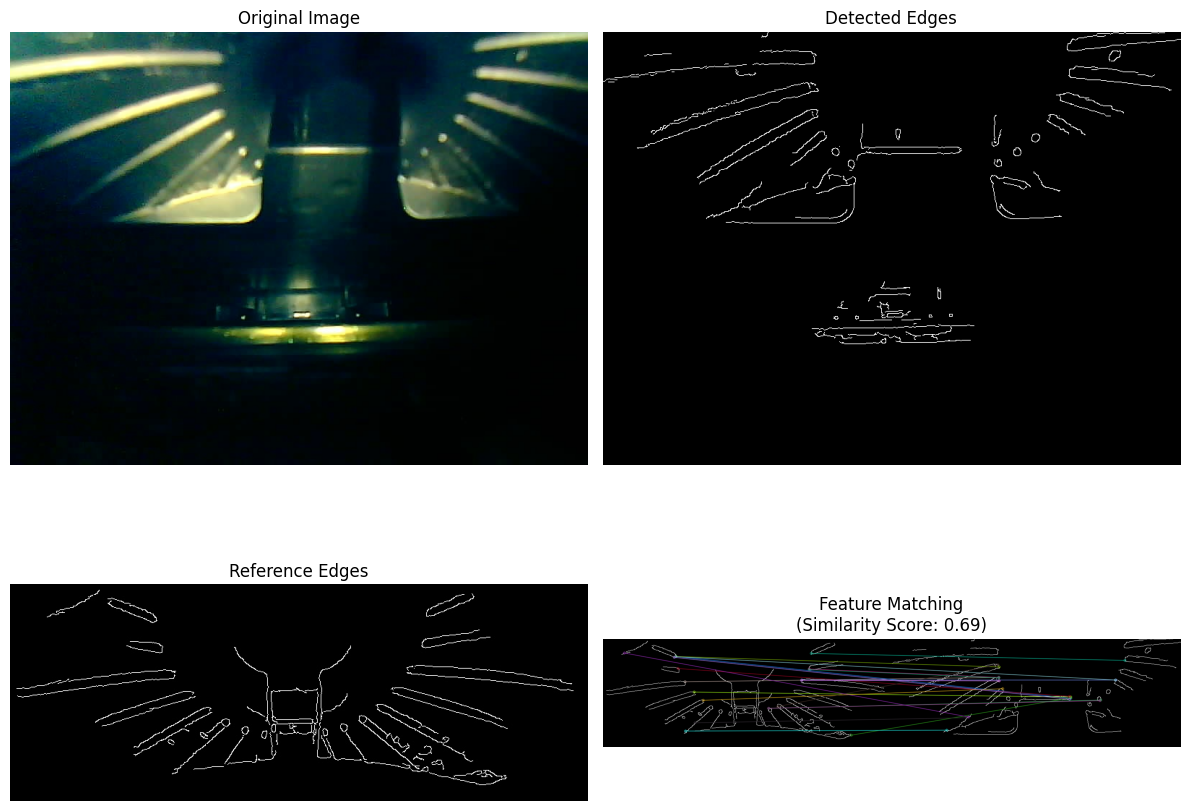

Kicker detected with similarity score: 0.69


True

In [38]:
detect_kicker_with_feature_matching('image collection/CV Image Collection/03 Kicker Detection/800x600/Invalid Case/Kicker in reverse orientation/Trial 3.jpg', reference_roi, reference_edges, threshold=0.5)

## For No Kicker

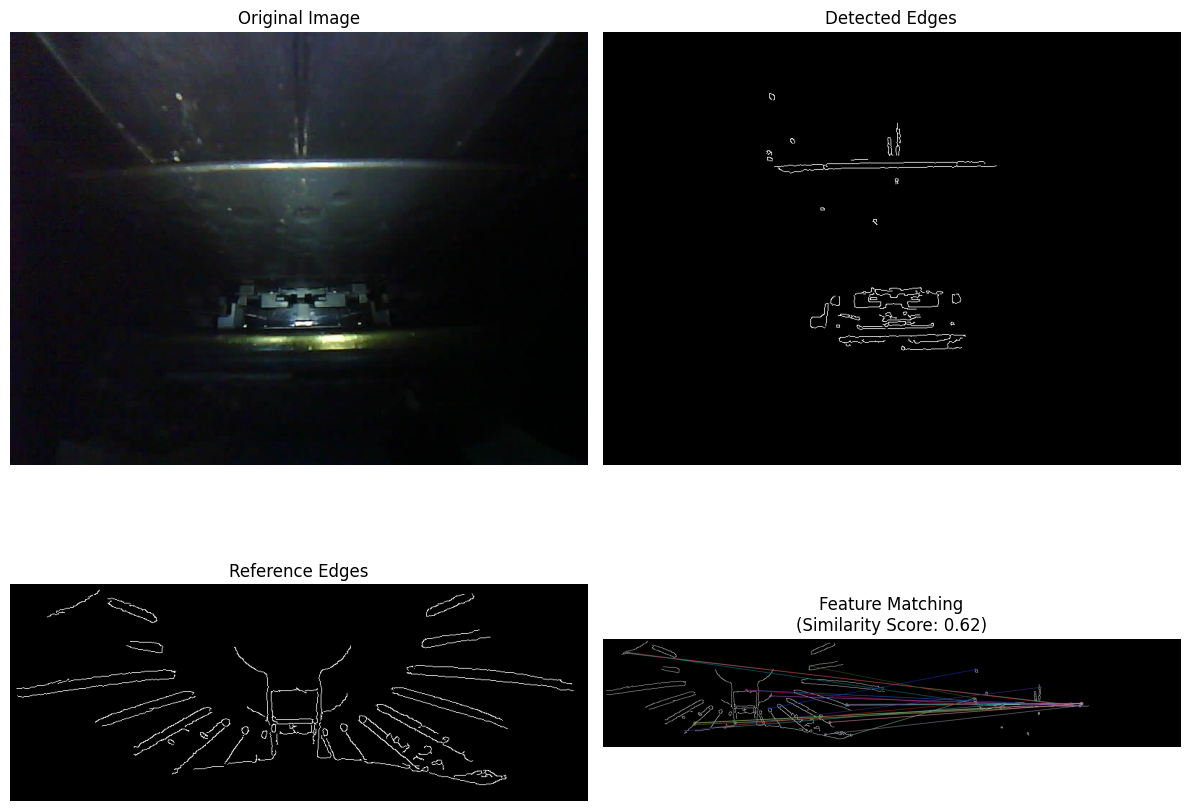

No kicker detected.


False

In [41]:
detect_kicker_with_feature_matching('image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at pos 100/Trial 1.jpg', reference_roi, reference_edges, threshold=0.7)

## Using Contours, Shape Matching

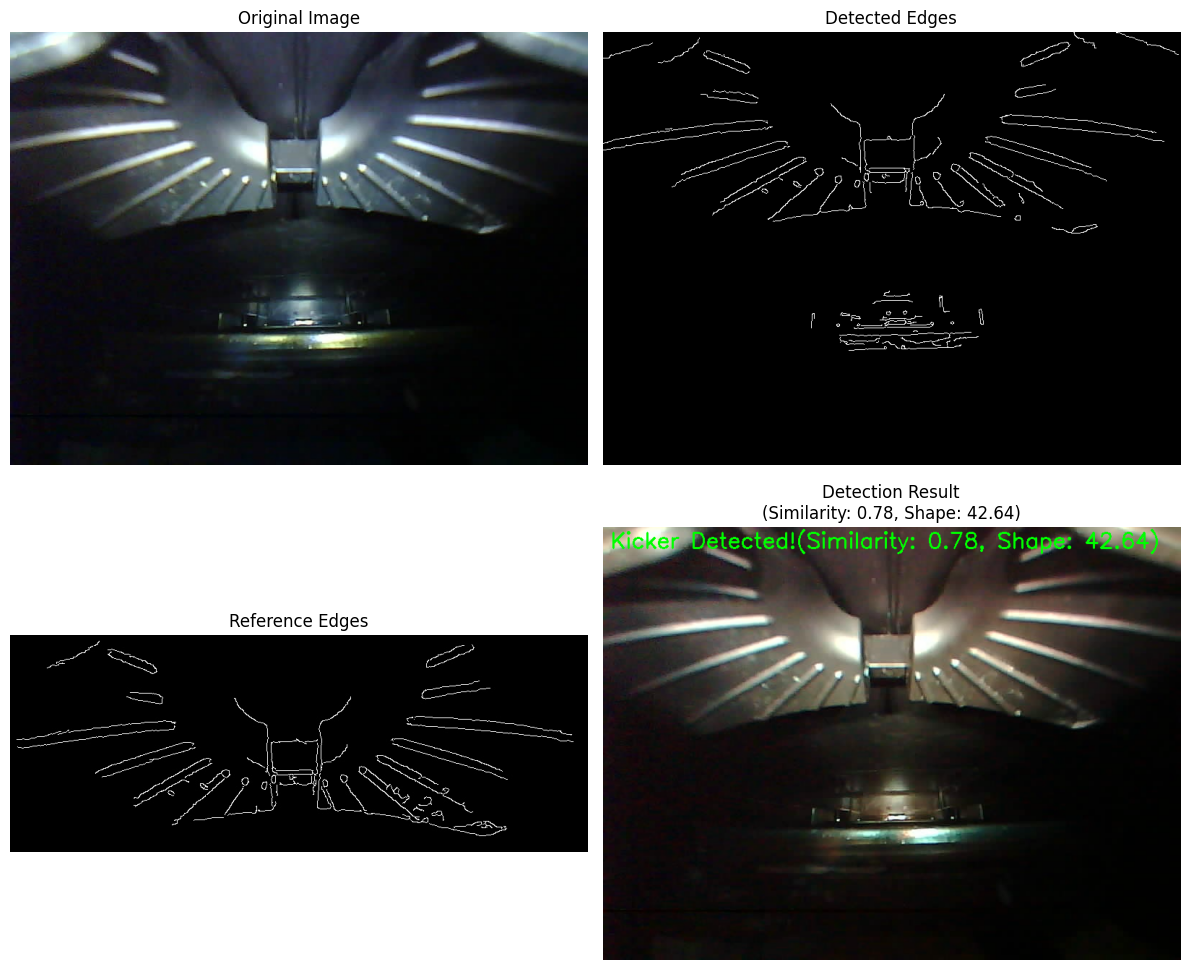

Kicker detected with similarity score: 0.78 and shape score: 42.64


True

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect kicker based on edge similarity using shape matching and feature matching
def detect_kicker_with_shape_and_feature(image_path, reference_roi, reference_edges, threshold=0.4):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return None  # Return None if the image is not found

    # Step 1: Image Preprocessing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Step 2: Edge Detection
    edges = cv2.Canny(blurred_image, 50, 150)

    # Step 3: Define ROI (upper half of the image)
    height, width = edges.shape
    roi = edges[0:int(height/2), 0:width]

    # Step 4: Contour Analysis
    contours_ref, _ = cv2.findContours(reference_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_roi, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours_ref or not contours_roi:
        print("No contours found in one of the images.")
        return None

    # Find the largest contour in the reference image (assumed to be the kicker)
    ref_contour = max(contours_ref, key=cv2.contourArea)

    # Shape Matching: Compare each contour in ROI to the reference contour
    shape_scores = []
    for contour in contours_roi:
        shape_score = cv2.matchShapes(ref_contour, contour, cv2.CONTOURS_MATCH_I1, 0.0)
        shape_scores.append(shape_score)
    
    # Minimum shape score indicates the closest match
    min_shape_score = min(shape_scores) if shape_scores else 1.0

    # Step 5: Feature Matching with ORB (or another method)
    orb = cv2.ORB_create()
    keypoints_ref, descriptors_ref = orb.detectAndCompute(reference_edges, None)
    keypoints_roi, descriptors_roi = orb.detectAndCompute(roi, None)

    # Create BFMatcher object based on Hamming distance (suitable for ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 

    if descriptors_ref is not None and descriptors_roi is not None:
        # Match descriptors
        matches = bf.match(descriptors_ref, descriptors_roi)
        matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance

        # Calculate similarity based on good matches
        good_matches = [m for m in matches if m.distance < 50]  # Threshold for good matches
        similarity_score = len(good_matches) / len(matches) if matches else 0  # Similarity score
    else:
        similarity_score = 0

    # Decision based on both shape matching and feature matching
    kicker_detected = (min_shape_score <= 50) and (similarity_score >= threshold)

    # Visualization
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Detected Edges")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(reference_edges, cmap='gray')
    plt.title("Reference Edges")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(image, cmap='gray')
    if kicker_detected:
        cv2.putText(image, f"Kicker Detected!(Similarity: {similarity_score:.2f}, Shape: {min_shape_score:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(image, "Kicker Not Detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    plt.imshow(image)
    plt.title(f"Detection Result\n(Similarity: {similarity_score:.2f}, Shape: {min_shape_score:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    if kicker_detected:
        print(f"Kicker detected with similarity score: {similarity_score:.2f} and shape score: {min_shape_score:.2f}")
    else:
        print("No kicker detected.")

    return kicker_detected

# Test the function with the reference images
reference_roi = cv2.imread('Reference_Imgs/reference_roi.jpg', cv2.IMREAD_GRAYSCALE)
reference_edges = cv2.imread('Reference_Imgs/reference_edges.jpg', cv2.IMREAD_GRAYSCALE)

detect_kicker_with_shape_and_feature('image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at front position/Trial 3.jpg', reference_roi, reference_edges, threshold=0.7)

## No Kicker

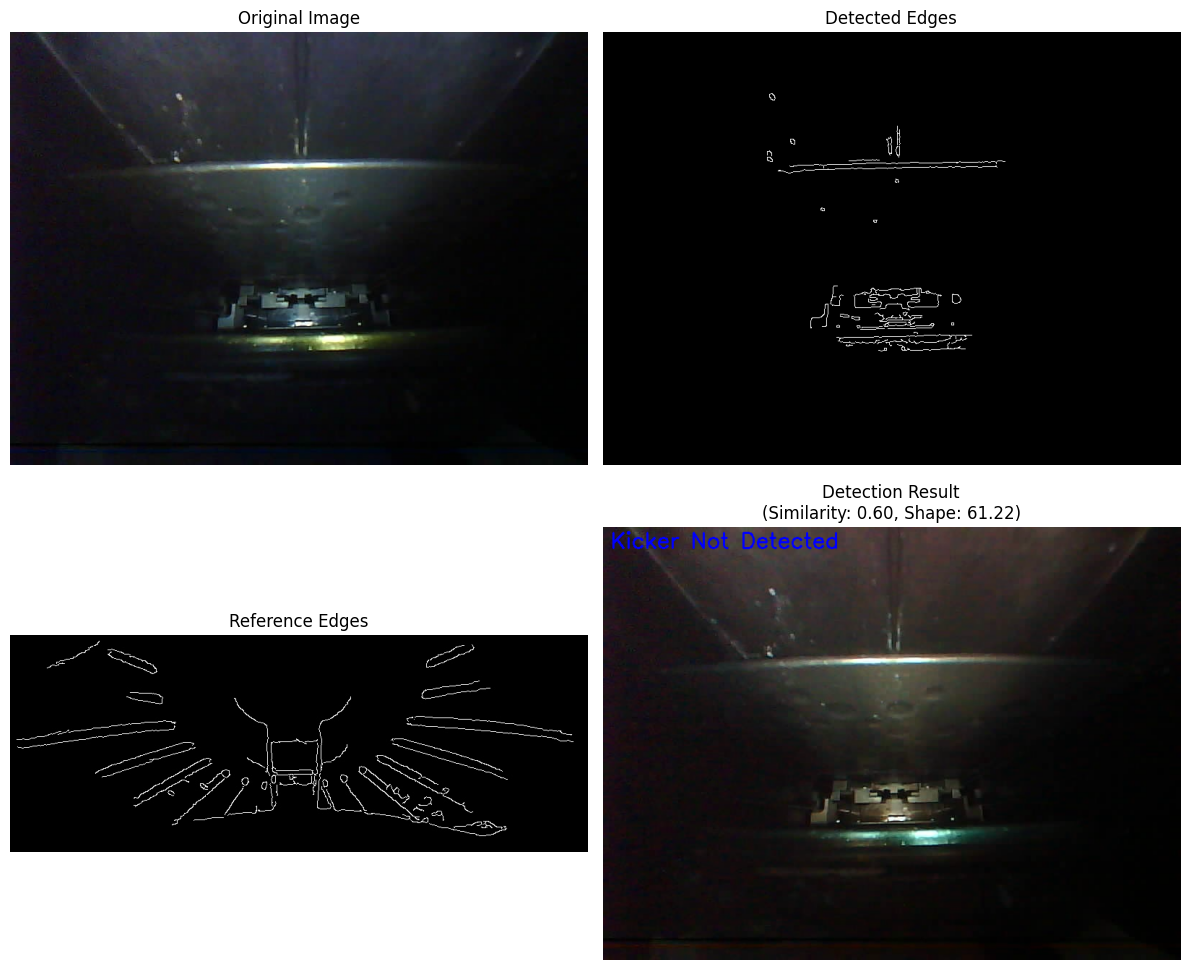

No kicker detected.


False

In [52]:
detect_kicker_with_shape_and_feature('image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at pos 100/Trial 3.jpg', reference_roi, reference_edges, threshold=0.7)

## Kicker at Invalid place

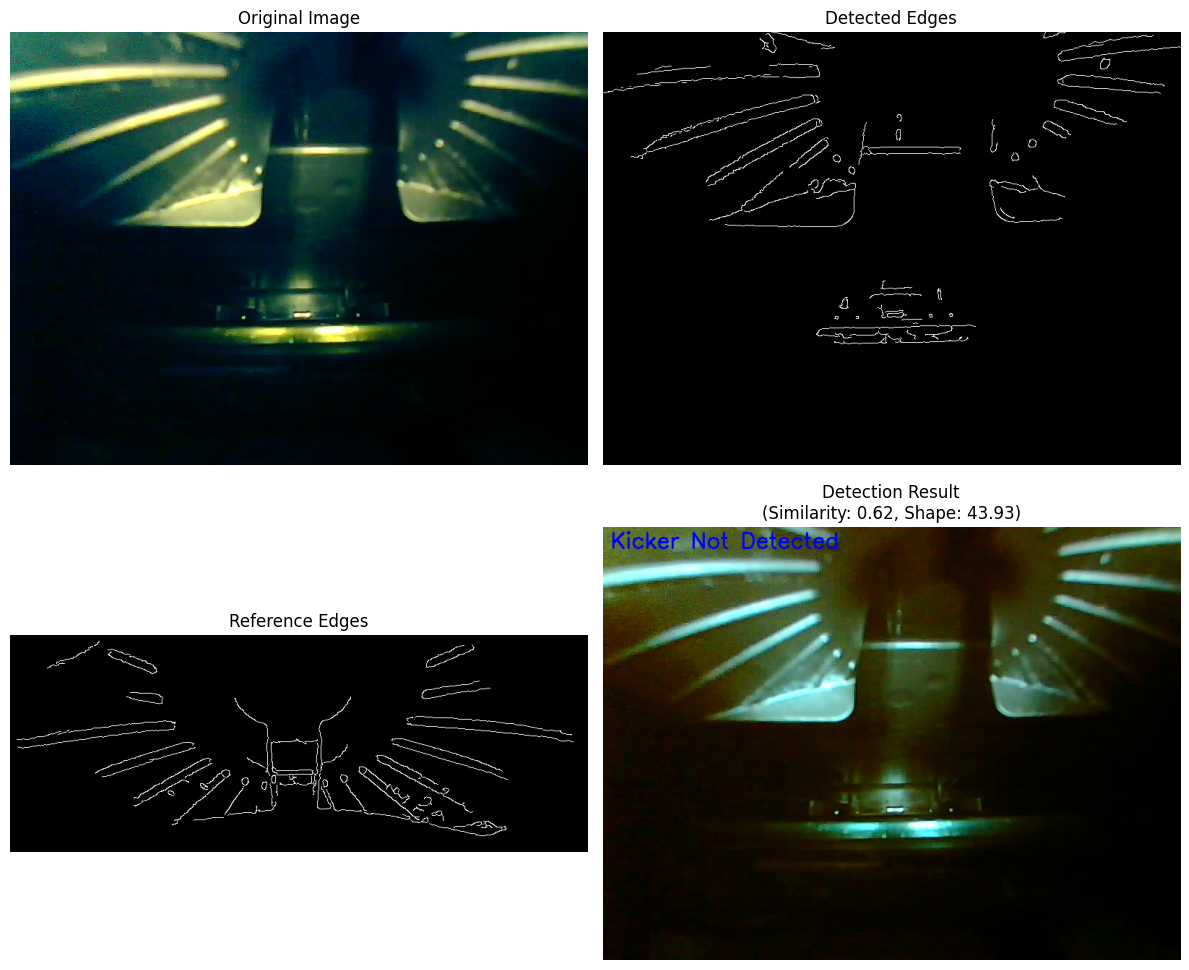

No kicker detected.


False

In [57]:
detect_kicker_with_shape_and_feature('image collection/CV Image Collection/03 Kicker Detection/800x600/Invalid Case/Kicker in reverse orientation/Trial 1.jpg', reference_roi, reference_edges, threshold=0.7)